In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
#dithering

def imgToUInt8(img):
    if np.issubdtype(img.dtype, np.unsignedinteger):
        return img
    else:
        img = img * 255
        img = img.astype('uint8')
        return img

def imgToFloat(img):
    if np.issubdtype(img.dtype, np.floating):
        return img
    else:
        img = img/255.0
        return img


def colorfit(color_value, color_palette):
    return color_palette[np.argmin(np.linalg.norm(color_value-color_palette, axis=1))]

def kwant_colorfit(img,Pallet):
        start = time.time()
        out_img = img.copy()
        for w in range(out_img.shape[0]):
                for k in range(out_img.shape[1]):
                        out_img[w,k]=colorfit(out_img[w,k],Pallet)

        end = time.time()

        elapsed_time = end - start
        print(f"Czas wykonania: {elapsed_time:.6f} sekundy")

        return out_img

#najprostsza w implementacji, najmniej dokładna, najmniej się polepsza dla większej
#ilości bitów
def dithering_random_old(img):
    # najprostsza wersja, uwzględnia szarości i kolory
    start = time.time()
    out_img = img.copy()
    if out_img.ndim == 3:
        r = np.random.rand(out_img.shape[0], out_img.shape[1], out_img.shape[2])
    else:
        r = np.random.rand(out_img.shape[0], out_img.shape[1])
    out_img = np.where(out_img >= r, 1, 0)

    end = time.time()
    elapsed_time = end - start
    print(f"Czas wykonania: {elapsed_time:.6f} sekundy")
    return out_img * 1

def dithering_random(img):
    start = time.time()
    out_img = img.copy()

    if out_img.ndim == 3:
        avg_gray = np.mean(out_img, axis=2, keepdims=True)  # średnia jasność
        r = np.random.rand(out_img.shape[0], out_img.shape[1], 1)
        out_img = np.where(avg_gray >= r, 1, 0)  # Porównanie ze średnią jasnością
    else:
        r = np.random.rand(out_img.shape[0], out_img.shape[1])
        out_img = np.where(out_img >= r, 1, 0)

    end = time.time()
    elapsed_time = end - start
    print(f"Czas wykonania: {elapsed_time:.6f} sekundy")
    return out_img * 1
#V2
#trudniejsza w implementacji, dobrze odwzorowuje oryginalny obraz
def dithering_organized(img, bayer_matrix=None, r=1, palette=None):
    start = time.time()
    out_img = img.copy()
    # obsługa koloru i szarości
    if img.ndim == 2:
        h, w = img.shape
        c = 1
        out_img = out_img[..., np.newaxis]
    else:
        h, w, c = img.shape

    n = bayer_matrix.shape[0] // 2
    p_matrix = ((bayer_matrix + 1) / ((2 * n) ** 2)) - 0.5

    pixel_x, pixel_y = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    new_pixel_x = (pixel_x % (2 * n)).astype(int)
    new_pixel_y = (pixel_y % (2 * n)).astype(int)

    for i in range(c):
        out_img[..., i] += r * p_matrix[new_pixel_x, new_pixel_y]

    kwant_out_img = kwant_colorfit(out_img, palette)

    # jeśli obraz jest szary, usuwamy nadmiar
    if c == 1:
        kwant_out_img = kwant_out_img[..., 0]

    end = time.time()
    elapsed_time = end - start
    print(f"Czas wykonania: {elapsed_time:.6f} sekundy")

    return kwant_out_img
'''
    oldpixel = img[x,y]
    newpixel = colorFit(oldpixel)
    img[x,y] = newpixel
    quant_error = oldpixel - newpixel
    img[x + 1,y    ] = img[x + 1,y    ] + quant_error × 7 / 16
    img[x - 1,y + 1] = img[x - 1,y + 1] + quant_error × 3 / 16
    img[x    ,y + 1] = img[x    ,y + 1] + quant_error × 5 / 16
    img[x + 1,y + 1] = img[x + 1,y + 1] + quant_error × 1 / 16
'''
def dithering_floyd(img, palette):
    start = time.time()
    h = img.shape[0]
    w = img.shape[1]
    for x in range(h):
        for y in range(w):
            oldpixel = img[x, y].copy()
            newpixel = colorfit(oldpixel, palette)
            img[x, y] = newpixel
            quant_error = oldpixel - newpixel
            if y < w - 1:
                img[x, y + 1] += quant_error * 7 / 16
            if x < h - 1:
                if y > 0:
                    img[x + 1, y - 1] += quant_error * 3 / 16
                img[x + 1, y] += quant_error * 5 / 16
                if y < w - 1:
                    img[x + 1, y + 1] += quant_error * 1 / 16

    end = time.time()
    elapsed_time = end - start
    print(f"Czas wykonania: {elapsed_time:.6f} sekundy")
    return img

def show_dithering_gray(img, palette, bayer=None, palette_name=None):
    fig = plt.figure(figsize=(16,9))
    gray = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    plt.subplot(1,5,1)
    plt.title(f"default")
    plt.imshow(gray, cmap='gray')

    gray_quant = kwant_colorfit(gray,palette)
    plt.subplot(1,5,2)
    plt.title(f"kwant")
    plt.imshow(gray_quant, cmap='gray')

    random_dithering = dithering_random(gray)
    plt.subplot(1,5,3)
    plt.title(f"random")
    plt.imshow(random_dithering, cmap='gray')

    organized_dithering = dithering_organized(gray, bayer_matrix=bayer, palette=palette)
    plt.subplot(1,5,4)
    plt.title(f"organized")
    plt.imshow(organized_dithering, cmap='gray')

    #dithering_floyd
    floyd_dithering = dithering_floyd(gray, palette)
    plt.subplot(1,5,5)
    plt.title(f"floyd")
    plt.imshow(floyd_dithering, cmap='gray')
    #print(np.unique(dithering_floyd(gray.copy(),np.linspace(0,1,2).reshape(2,1))).size)
    fig.suptitle(f"Algorytmu ditheringu dla palety {palette_name}", fontsize=16)
    plt.tight_layout()
    plt.show()
    return

def show_dithering_color(img, palette, bayer=None, palette_name=None):
    img_rgb = img.copy()
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.title(f"default")
    plt.imshow(img_rgb)

    color_quant = kwant_colorfit(img_rgb,palette)
    plt.subplot(1,5,2)
    plt.title(f"kwant")
    plt.imshow(color_quant)

    random_dithering = dithering_random(img_rgb)
    plt.subplot(1,5,3)
    plt.title(f"random")
    plt.imshow(random_dithering)

    organized_dithering = dithering_organized(img_rgb, bayer_matrix=bayer, palette=palette)
    plt.subplot(1,5,4)
    plt.title(f"organized")
    plt.imshow(organized_dithering)

    #dithering_floyd
    floyd_dithering = dithering_floyd(img_rgb, palette)
    plt.subplot(1,5,5)
    plt.title(f"floyd")
    plt.imshow(floyd_dithering)

    #print(np.unique(dithering_floyd(img_rgb.copy(),np.linspace(0,1,2).reshape(2,1))).size)
    fig.suptitle(f"Algorytmu ditheringu dla palety {palette_name}", fontsize=16)
    plt.tight_layout()
    plt.show()
    return

#i cant to jest tak sprytne
#https://codegolf.stackexchange.com/questions/259633/make-a-custom-bayer-matrix
def generate_bayer_matrix(n):
    f=lambda n:n and np.kron(np.c_[[0,3],[2,1]]-4j,1j-f(n-1)).imag
    return f(n)

def show_dithering_organized_gray(img ,palette, bayerSize, palette_name):
    gray = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    fig = plt.figure(figsize=(16,9))
    n = 2
    pos = 1
    length = int(np.log2(bayerSize))
    while n <= bayerSize:
        size = np.log2(n).astype(int)
        bayer_matrix = generate_bayer_matrix(size).astype(int)
        #print(bayer_matrix.shape[0])
        plt.subplot(1, length, pos)
        organized_dithering = dithering_organized(gray, bayer_matrix=bayer_matrix, palette=palette)
        plt.imshow(organized_dithering, cmap='gray')
        plt.title(f"bayer {n}x{n}")
        pos += 1
        n = n * 2

    fig.suptitle(f"Organized dithering {palette_name}", fontsize=16)
    plt.tight_layout()
    plt.show()
    return

def show_dithering_organized_color(img ,palette, bayerSize, palette_name):
    img_rgb = img.copy()
    fig = plt.figure(figsize=(16,9))
    n = 2
    pos = 1
    length = int(np.log2(bayerSize))
    while n <= bayerSize:
        size = np.log2(n).astype(int)
        bayer_matrix = generate_bayer_matrix(size).astype(int)
        #print(bayer_matrix)
        plt.subplot(1, length, pos)
        organized_dithering = dithering_organized(img_rgb, bayer_matrix=bayer_matrix, palette=palette)
        plt.imshow(organized_dithering)
        plt.title(f"bayer {n}x{n}")
        pos += 1
        n = n * 2

    fig.suptitle(f"Organized dithering {palette_name}", fontsize=16)
    plt.tight_layout()
    plt.show()
    return

In [ ]:
pallet1bit = np.linspace(0,1,2).reshape(2,1)
pallet2bit = np.linspace(0,1,4).reshape(4,1)
pallet4bit = np.linspace(0,1,16).reshape(16,1)


pallet8 = np.array([
        [0.0, 0.0, 0.0,],
        [0.0, 0.0, 1.0,],
        [0.0, 1.0, 0.0,],
        [0.0, 1.0, 1.0,],
        [1.0, 0.0, 0.0,],
        [1.0, 0.0, 1.0,],
        [1.0, 1.0, 0.0,],
        [1.0, 1.0, 1.0,],
])


pallet16 =  np.array([
        [0.0, 0.0, 0.0,],
        [0.0, 1.0, 1.0,],
        [0.0, 0.0, 1.0,],
        [1.0, 0.0, 1.0,],
        [0.0, 0.5, 0.0,],
        [0.5, 0.5, 0.5,],
        [0.0, 1.0, 0.0,],
        [0.5, 0.0, 0.0,],
        [0.0, 0.0, 0.5,],
        [0.5, 0.5, 0.0,],
        [0.5, 0.0, 0.5,],
        [1.0, 0.0, 0.0,],
        [0.75, 0.75, 0.75,],
        [0.0, 0.5, 0.5,],
        [1.0, 1.0, 1.0,],
        [1.0, 1.0, 0.0,]
])
m1bayer = np.array([
    [0, 2],
    [3, 1]
])
m2bayer = np.array([
    [0, 8, 2, 10],
    [12, 4, 14, 6],
    [3, 11, 1, 9],
    [15, 7, 13, 5]
])

<ipython-input-12-68dfe0895eca>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out_img[w,k]=colorfit(out_img[w,k],Pallet)


Czas wykonania: 0.557050 sekundy
Czas wykonania: 0.000826 sekundy
Czas wykonania: 0.496670 sekundy
Czas wykonania: 0.498728 sekundy


<ipython-input-12-68dfe0895eca>:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img[x, y] = newpixel
<ipython-input-12-68dfe0895eca>:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img[x, y + 1] += quant_error * 7 / 16
<ipython-input-12-68dfe0895eca>:139: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img[x + 1, y] += quant_error * 5 / 16
<ipython-input-12-68dfe0895eca>:141: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, an

Czas wykonania: 2.476060 sekundy


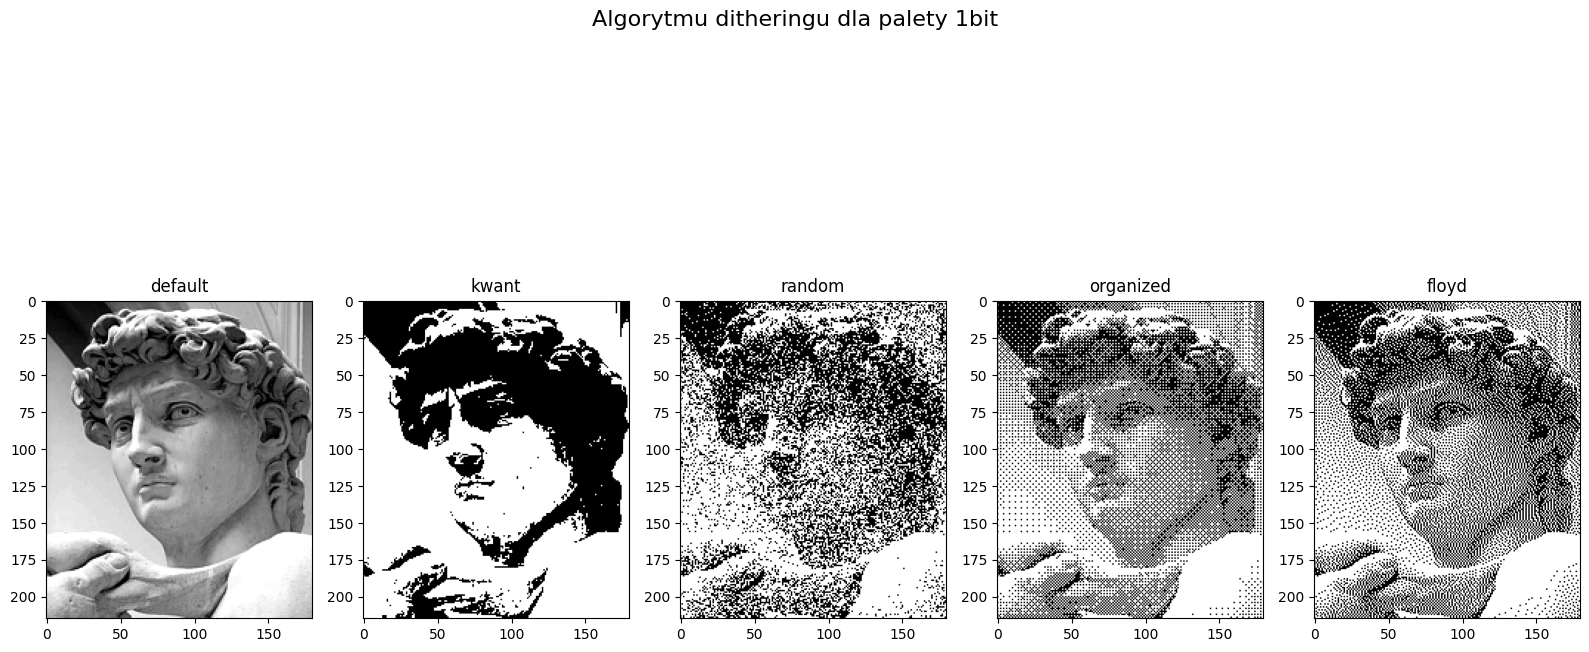

Czas wykonania: 0.581610 sekundy
Czas wykonania: 0.000711 sekundy
Czas wykonania: 0.621377 sekundy
Czas wykonania: 0.623290 sekundy
Czas wykonania: 2.327487 sekundy


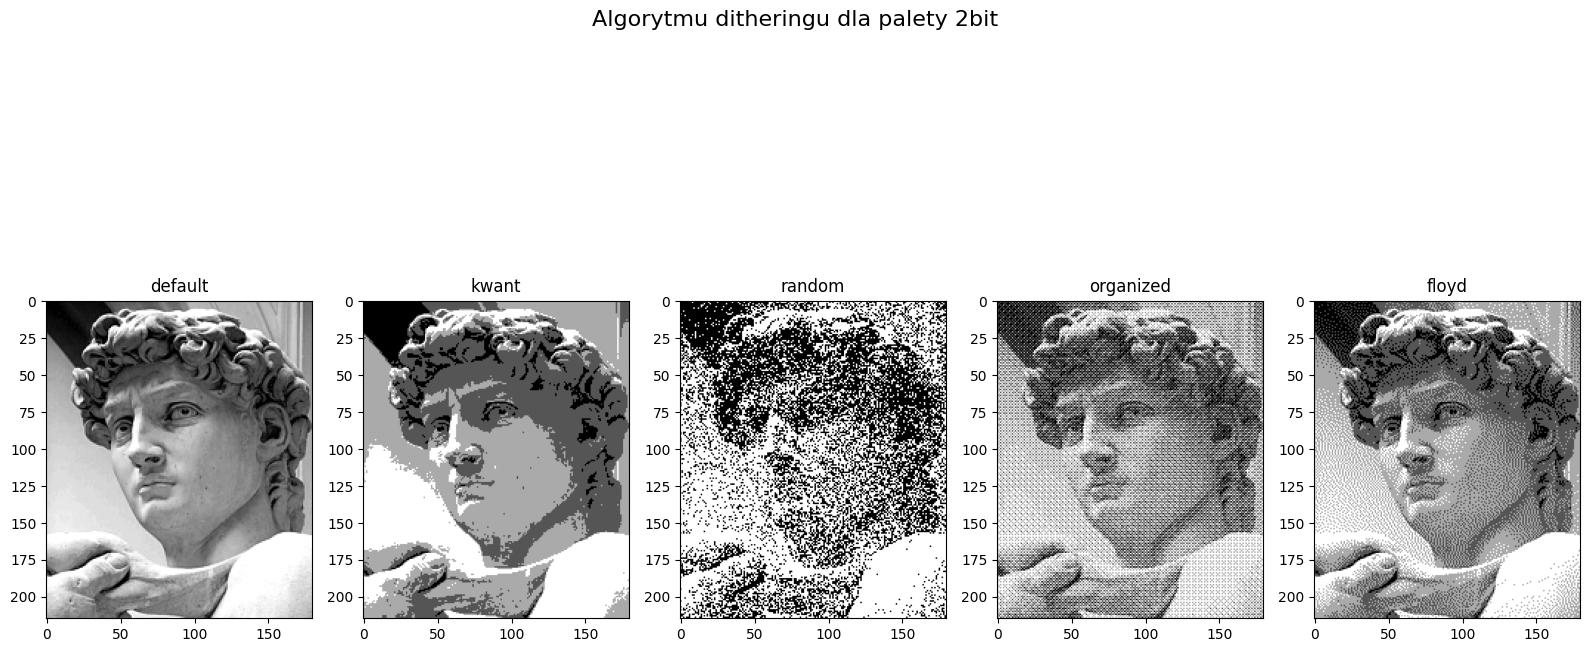

Czas wykonania: 0.690316 sekundy
Czas wykonania: 0.000969 sekundy
Czas wykonania: 0.673571 sekundy
Czas wykonania: 0.676594 sekundy
Czas wykonania: 2.315272 sekundy


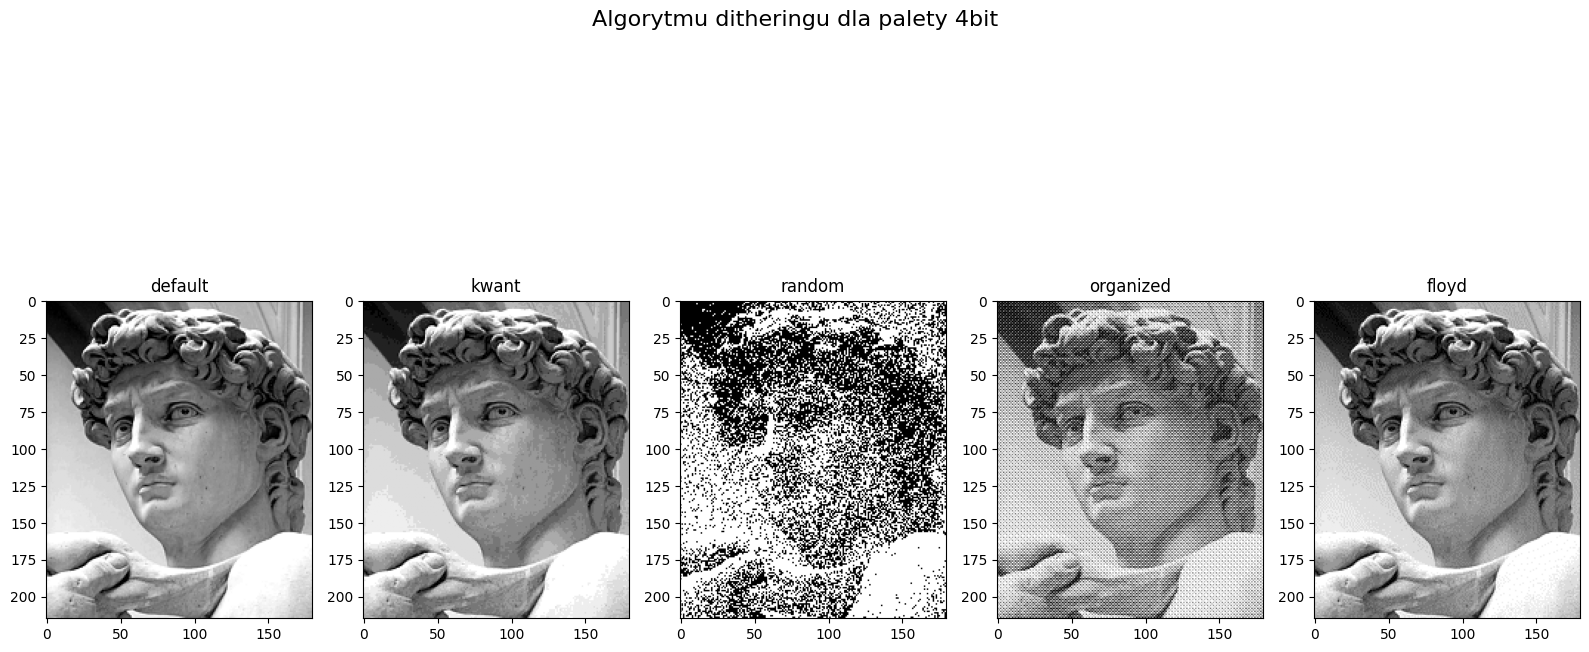

Czas wykonania: 0.665576 sekundy
Czas wykonania: 0.668453 sekundy
Czas wykonania: 0.425060 sekundy
Czas wykonania: 0.426947 sekundy
Czas wykonania: 0.462282 sekundy
Czas wykonania: 0.464169 sekundy
Czas wykonania: 0.506976 sekundy
Czas wykonania: 0.509023 sekundy
Czas wykonania: 0.714650 sekundy
Czas wykonania: 0.716543 sekundy
Czas wykonania: 0.430766 sekundy
Czas wykonania: 0.432904 sekundy


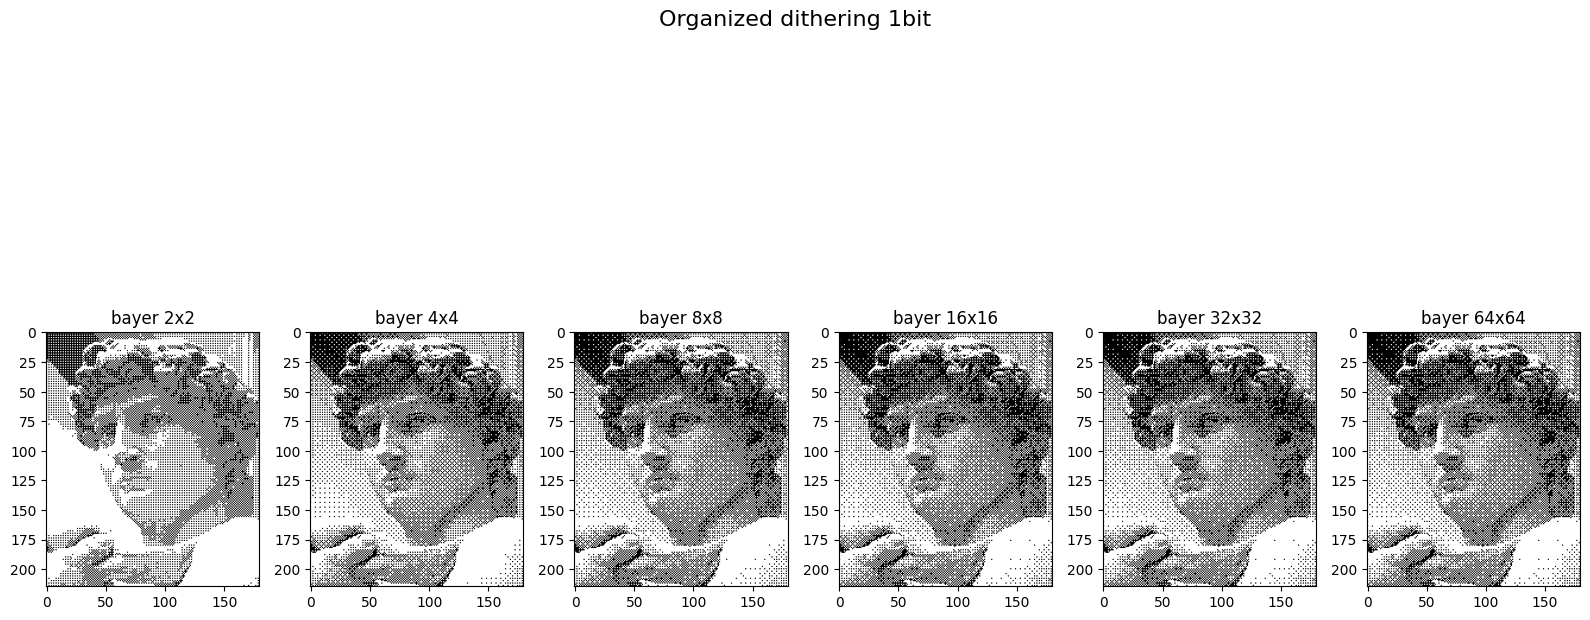

Czas wykonania: 0.466720 sekundy
Czas wykonania: 0.469423 sekundy
Czas wykonania: 0.426833 sekundy
Czas wykonania: 0.429424 sekundy
Czas wykonania: 0.731363 sekundy
Czas wykonania: 0.733750 sekundy
Czas wykonania: 0.494303 sekundy
Czas wykonania: 0.496268 sekundy
Czas wykonania: 0.551615 sekundy
Czas wykonania: 0.553509 sekundy
Czas wykonania: 0.678392 sekundy
Czas wykonania: 0.681066 sekundy


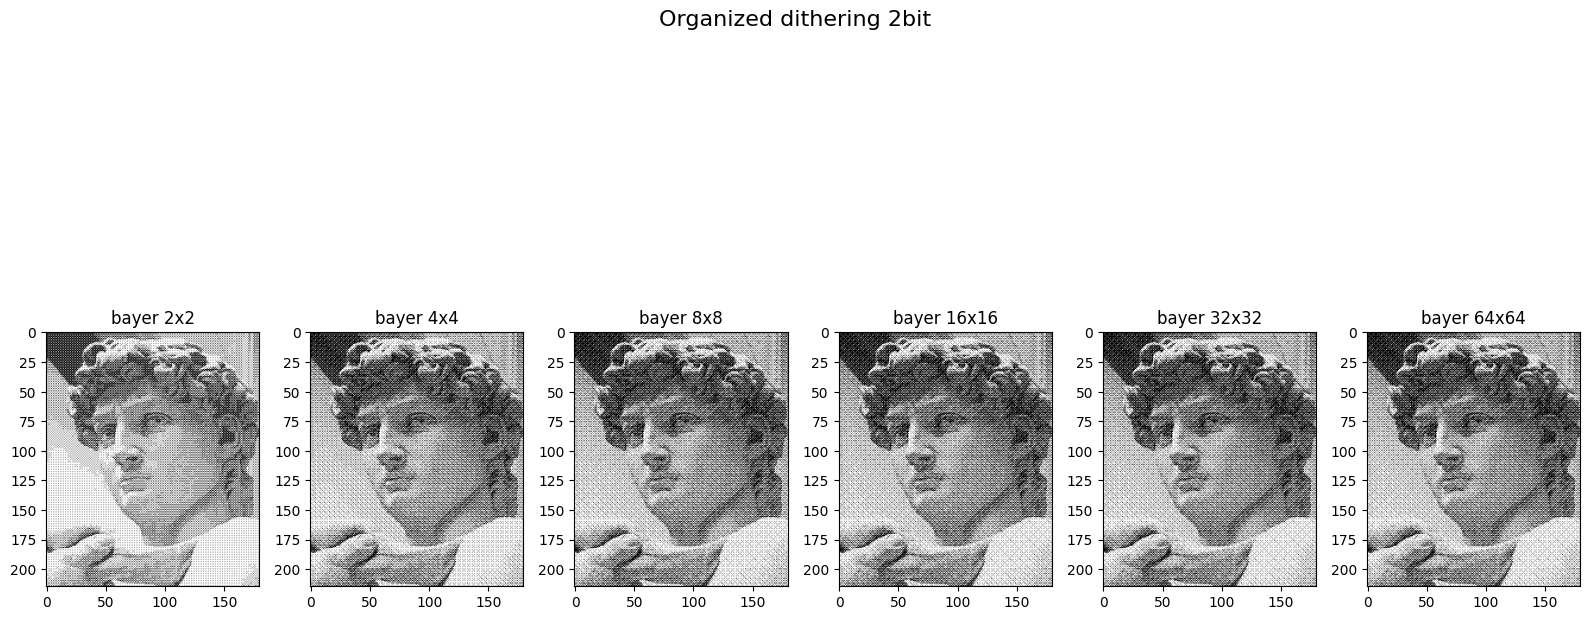

Czas wykonania: 0.689228 sekundy
Czas wykonania: 0.691838 sekundy
Czas wykonania: 0.445400 sekundy
Czas wykonania: 0.447404 sekundy
Czas wykonania: 0.591888 sekundy
Czas wykonania: 0.593955 sekundy
Czas wykonania: 0.496740 sekundy
Czas wykonania: 0.499038 sekundy
Czas wykonania: 0.480242 sekundy
Czas wykonania: 0.482186 sekundy
Czas wykonania: 0.507485 sekundy
Czas wykonania: 0.509431 sekundy


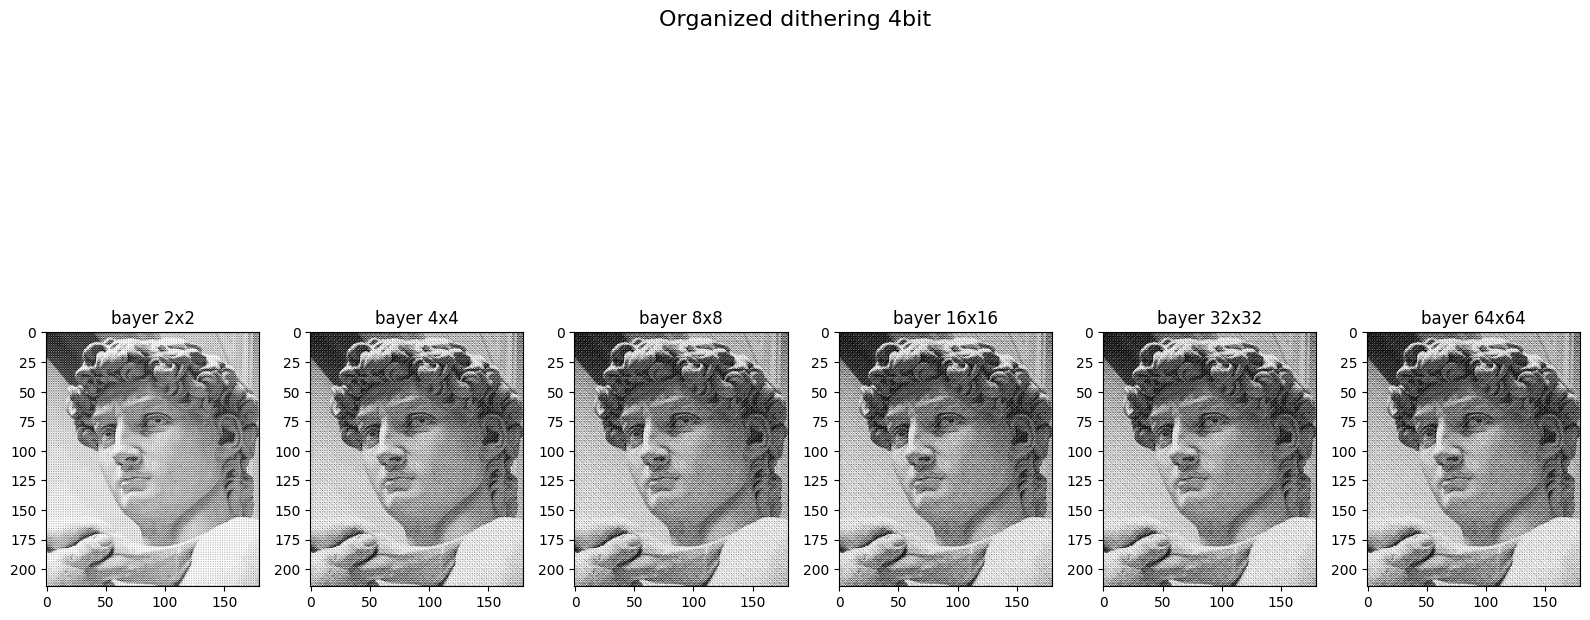

Czas wykonania: 0.169353 sekundy
Czas wykonania: 0.000783 sekundy
Czas wykonania: 0.193722 sekundy
Czas wykonania: 0.194875 sekundy
Czas wykonania: 0.388968 sekundy


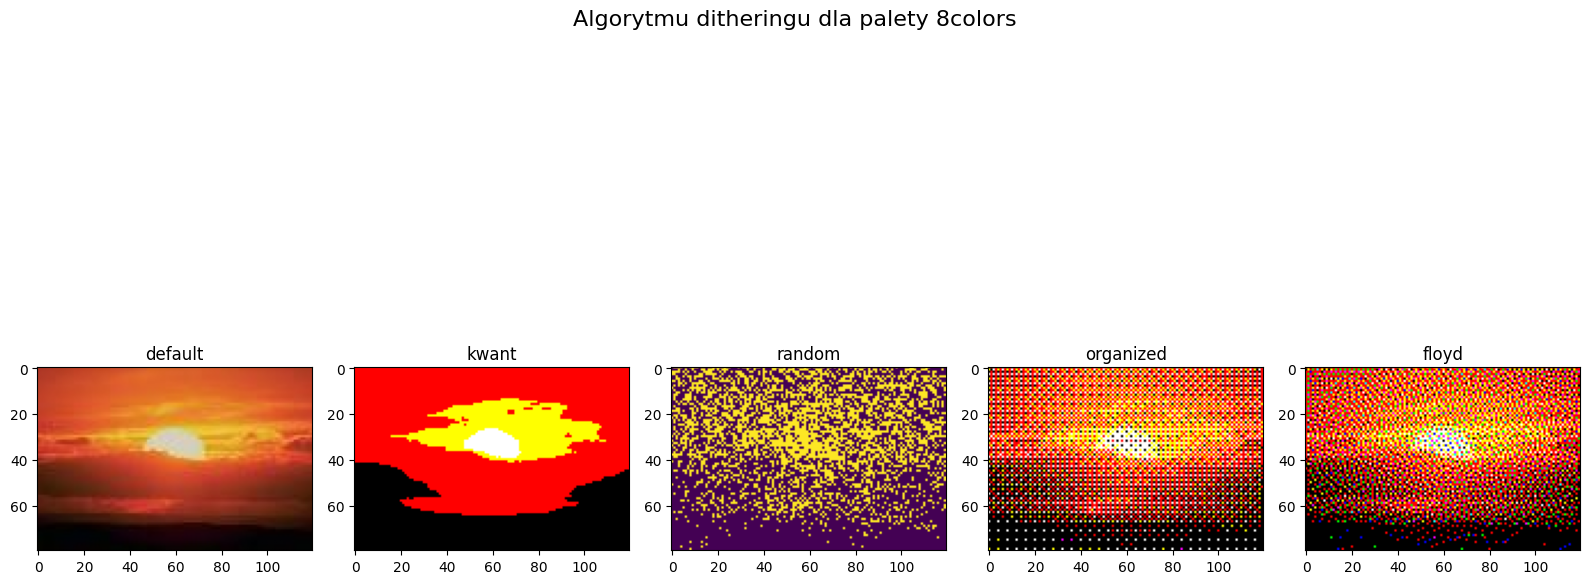

Czas wykonania: 0.186154 sekundy
Czas wykonania: 0.000635 sekundy
Czas wykonania: 0.093540 sekundy
Czas wykonania: 0.094445 sekundy
Czas wykonania: 0.333266 sekundy


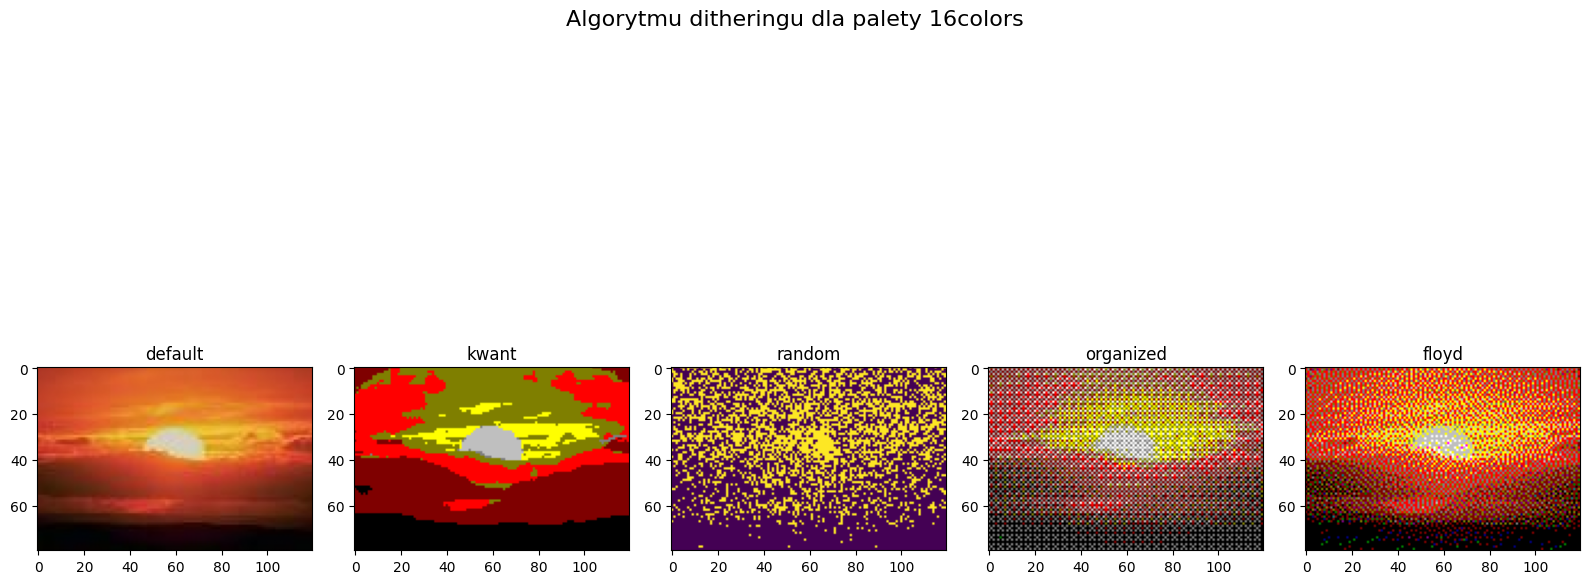

Czas wykonania: 0.180509 sekundy
Czas wykonania: 0.182086 sekundy
Czas wykonania: 0.103779 sekundy
Czas wykonania: 0.104686 sekundy
Czas wykonania: 0.175611 sekundy
Czas wykonania: 0.176584 sekundy
Czas wykonania: 0.143655 sekundy
Czas wykonania: 0.144796 sekundy
Czas wykonania: 0.142121 sekundy
Czas wykonania: 0.143052 sekundy
Czas wykonania: 0.102622 sekundy
Czas wykonania: 0.103485 sekundy


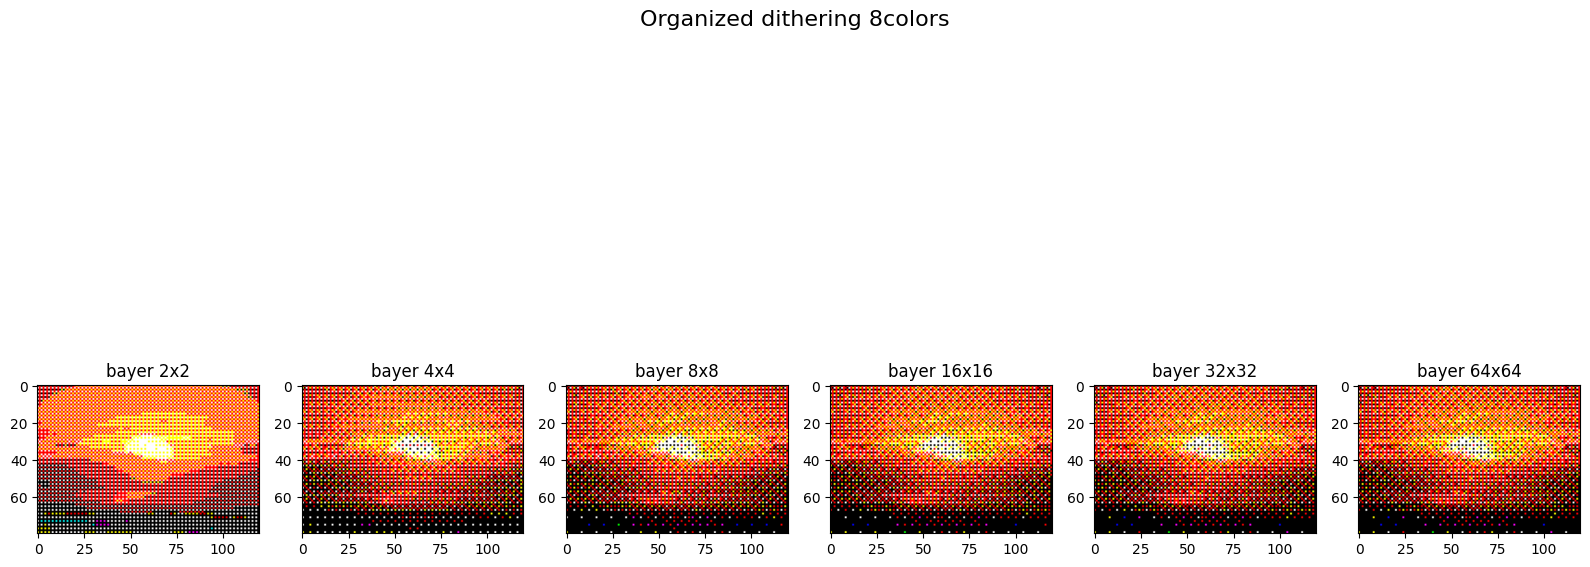

Czas wykonania: 0.158659 sekundy
Czas wykonania: 0.160544 sekundy
Czas wykonania: 0.107114 sekundy
Czas wykonania: 0.107927 sekundy
Czas wykonania: 0.116054 sekundy
Czas wykonania: 0.118205 sekundy
Czas wykonania: 0.128946 sekundy
Czas wykonania: 0.130133 sekundy
Czas wykonania: 0.141407 sekundy
Czas wykonania: 0.142587 sekundy
Czas wykonania: 0.094760 sekundy
Czas wykonania: 0.095625 sekundy


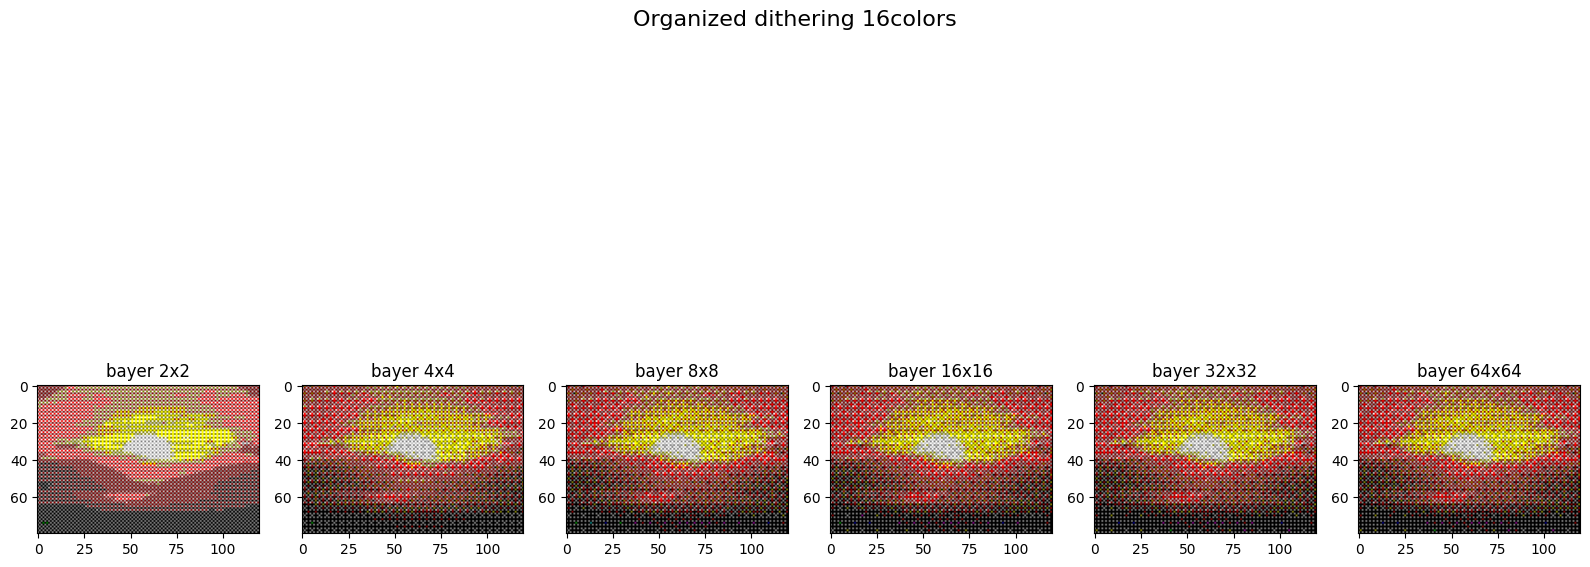

In [ ]:
img = plt.imread('/content/GS_0002.png')

show_dithering_gray(img, palette=pallet1bit, bayer=m2bayer, palette_name="1bit")
show_dithering_gray(img, palette=pallet2bit, bayer=m2bayer, palette_name="2bit")
show_dithering_gray(img, palette=pallet4bit, bayer=m2bayer, palette_name="4bit")

show_dithering_organized_gray(img, palette=pallet1bit, bayerSize=64, palette_name="1bit")
show_dithering_organized_gray(img, palette=pallet2bit, bayerSize=64, palette_name="2bit")
show_dithering_organized_gray(img, palette=pallet4bit, bayerSize=64, palette_name="4bit")

img = plt.imread('/content/SMALL_0004.jpg')
img = imgToFloat(img)

show_dithering_color(img, palette=pallet8, bayer=m2bayer, palette_name="8colors")
show_dithering_color(img, palette=pallet16, bayer=m2bayer, palette_name="16colors")

show_dithering_organized_color(img, palette=pallet8, bayerSize=64, palette_name="8colors")
show_dithering_organized_color(img, palette=pallet16, bayerSize=64, palette_name="16colors")